In [1]:
# import necessary modules and libraries
import os
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
import glob
from google.colab import drive
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
# mount google drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
# add base path to folder
base_path = "/gdrive/MyDrive/art_style_transfer/"

# Content and style subfolder names
content_subfolder = "train"
style_subfolder = "art"

content_folder_path = os.path.join(base_path, content_subfolder)
style_folder_path = os.path.join(base_path, style_subfolder)

content_files = os.listdir(content_folder_path)
style_files = os.listdir(style_folder_path)

content_paths = []
style_paths = []

# Iterate over the files and store content and style paths
for content_image_name, style_image_name in zip(content_files, style_files):
    content_path = os.path.join(content_folder_path, content_image_name)
    style_path = os.path.join(style_folder_path, style_image_name)
    content_paths.append(content_path)
    style_paths.append(style_path)

## Pre-processing and Visulaizing input images
Define functions to load content and style images, pre-process and display them

In [4]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [5]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [6]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [7]:
content_images = []
style_images = []

for content_path, style_path in zip(content_paths, style_paths):
    content_img = load_img(content_path)
    style_img = load_img(style_path)
    content_images.append(content_img)
    style_images.append(style_img)

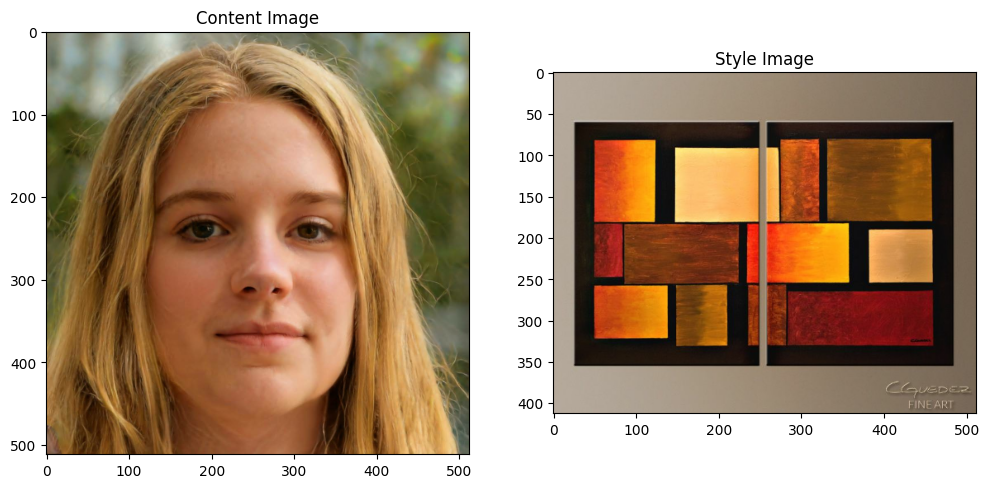

In [11]:
plt.subplot(1, 2, 1)
imshow(content_images[7], 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_images[5], 'Style Image')

## VGG19 Model Configuration


In [15]:
# load model without classification layer
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

In [17]:
# Extract intermediate layers from the model to represent the style and content of the image
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [19]:
# function to build the model
def vgg_layers(layer_names):
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

## Calculate Style
The content of an image is represented by the values of the intermediate feature maps. The style of an image can be described using different feature maps.

Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations.

In [20]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [21]:
# construct class that returns style and content tensors
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [22]:
# extract features from style layers
style_extractor = vgg_layers(style_layers)

# Compute the style of the style_layers and content of the content_layers
extractor = StyleContentModel(style_layers, content_layers)

In [26]:
# define function to keep pixxel values of image between 0 and 1
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [24]:
# define optimizer and hyperparameters
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e4
total_variation_weight=30

In [25]:
# define function to compute style and content loss
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

## Training loop

In [27]:
# define the training step that performs gradient descent and implement style tranform algorithm
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss = loss + total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [28]:
# Extract style and content targets using the StyleContentModel
style_targets = extractor(style_images[5])['style']
content_targets = extractor(content_images[7])['content']
img = tf.Variable(content_images[7])

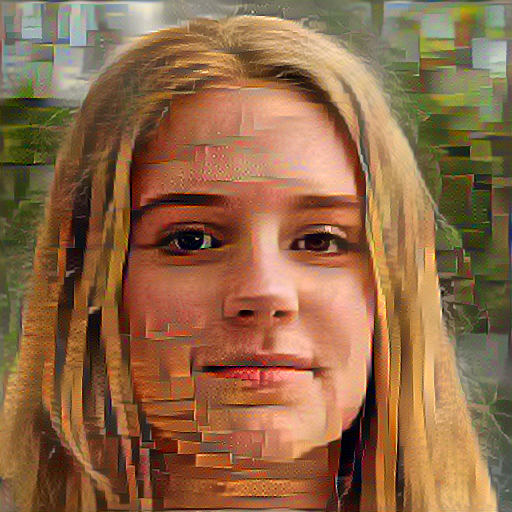

Train step: 1000
Total time: 174.6


In [29]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(img)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(img))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

## Inference

In [30]:
# function to perform artistic style tranfer and display the final image
def style_img(img):
  step = 0
  for n in range(10):
    for m in range(100):
      step += 1
      with tf.GradientTape() as tape:
        outputs = extractor(img)
        loss = style_content_loss(outputs)
        loss = loss + total_variation_weight*tf.image.total_variation(img)
      grad = tape.gradient(loss, img)
      opt.apply_gradients([(grad, img)])
      img.assign(clip_0_1(img))
  display.clear_output(wait=True)
  display.display(tensor_to_image(img))

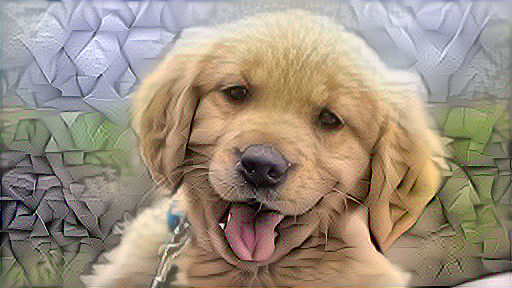

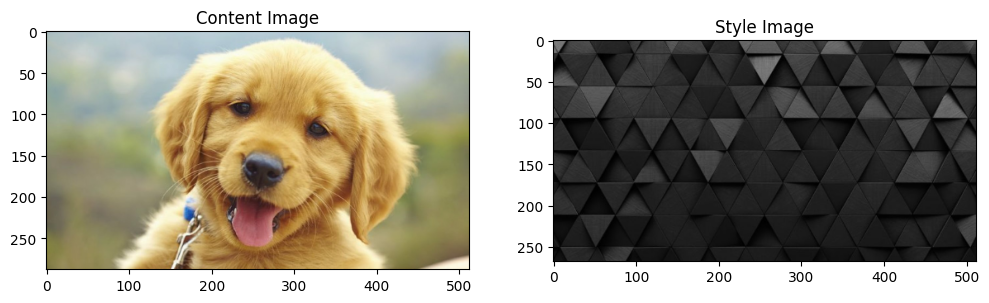

In [33]:
# example 1 displaying original content and style image, and the tranformed image
plt.subplot(1, 2, 1)
imshow(content_images[5], 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_images[7], 'Style Image')

style_targets = extractor(style_images[7])['style']
content_targets = extractor(content_images[5])['content']
img = tf.Variable(content_images[5])
style_img(img)

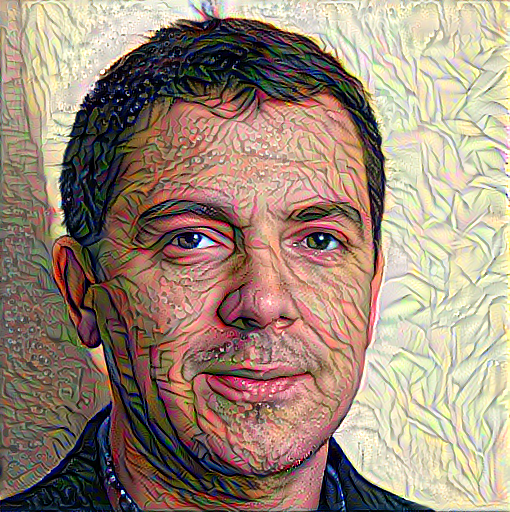

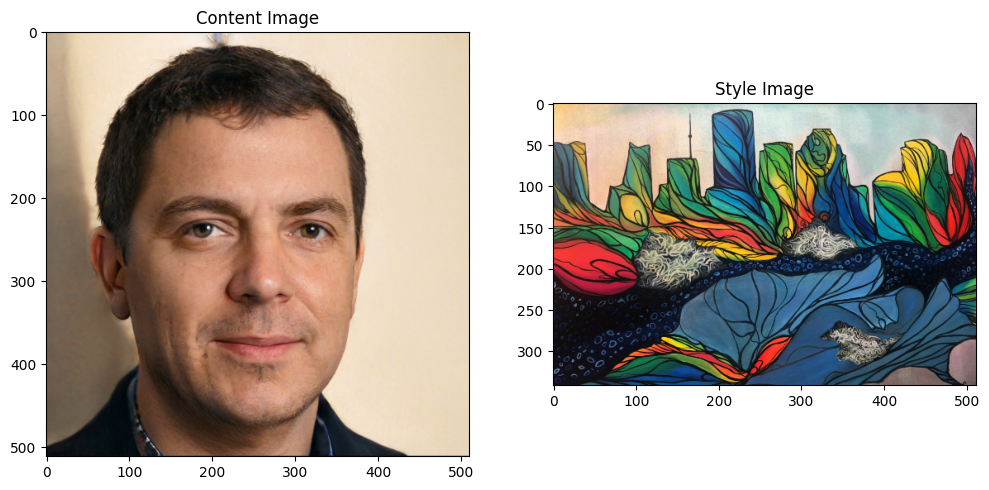

In [32]:
# example 2
plt.subplot(1, 2, 1)
imshow(content_images[6], 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_images[0], 'Style Image')

style_targets = extractor(style_images[0])['style']
content_targets = extractor(content_images[6])['content']
img = tf.Variable(content_images[6])
style_img(img)

## Evaluation

In [34]:
# Function to calculate content preservation accuracy
def content_preservation_accuracy_percentage(original_features, transformed_features):
    mse = tf.reduce_mean(tf.square(original_features - transformed_features))
    max_mse = tf.reduce_mean(tf.square(original_features - 0.0))
    accuracy_percentage = (1.0 - mse / max_mse) * 100.0
    return accuracy_percentage.numpy()

In [36]:
# Extract content features for the original and transformed images
original_content_features = extractor(content_images[5])['content']['block5_conv2']
transformed_content_features = extractor(img)['content']['block5_conv2']

# calculate accuracy for example 1
accuracy_percentage = content_preservation_accuracy_percentage(original_content_features, transformed_content_features)
print(f"Content Preservation Accuracy: {accuracy_percentage:.2f}%")

Content Preservation Accuracy: 85.59%


## Limitations and Potential Improvements


*   Since it is an unsupervised learning problem, therefore we do not have the exact target image that is required after applying the tranformation. We may not have an initial idea as to what extent the style needs to be transferred, i.e. it may happen that the content of the original image may be lost by a large margin.
*   The model involves an iterative approach to transform the base content image. Each iteration involves updating the image through optimization os loss function upto the point it converges to the desired stylization. Thus, it requires a significant time to perform style transfer on the individual base image.
*   A potential improvement in the code could be to devise a strategy to speed up the syle transfer process.
* Since the code is sensitive on various hyperparameters such as style weight, content weight, and total variation weight, therefore, it may be difficult to find a correct balance between different hyperparameters\.
*  Another potential improvement could be to extend the code for multiple-style transfer involving the artistic transfer of multiple abstract images on the base content image.
*  Further scope of the model involves generating diverse set of visual comic images by performing artistic style transfer of different styles and backgrounds onto the base image. The model can be enhanced to incorporate dynamic backgrounds and atmospheric effects by transferring the styles to specific protion of the base image.




